## Import TensorFlow and other libraries

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU

from keras.models import Model
from keras import backend as K

from PIL import Image, ImageDraw
from random import seed
from random import random, uniform
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import random

In [39]:
print('Tensorflow Version : {}'.format(tf.__version__))

Tensorflow Version : 2.9.1


In [40]:
saveDir='Disk-Hole_Validation-L2/'

## Load the dataset

### Generate Disk Image DataSet


In [41]:
w, h = 64, 64 # Image Size

#generate data for training

num_images_train=15000
radius_train=[]
x_train =[]
for i in range(num_images_train):
    value = uniform(0.1, 0.999)
    eX, eY = value*w, value*h #Size of Bounding Box for a disk (disk diameter)
    eX=round(eX,2)
    eY=eX
    radius_train.append(eX/2)    
    shape =  (w/2 - eX/2, h/2 - eY/2, w/2 + eX/2, h/2 + eY/2) # four corners the bounding box for a disk
    image = Image.new('L', (w, h), 'black')
    draw = ImageDraw.Draw(image)
    draw.ellipse(shape, fill = 'white', outline ='black')
    img_array=np.asarray(image)
    x_train.append(img_array)
    image.save('disk_data_train/disk'+str(i)+'.png')

x_train = np.array(x_train)
df_train=pd.DataFrame(radius_train)
df_train.to_csv('disk_data_train/radius_train.csv')

#generate data for testing 

num_images_test=2000
radius_test=[]
x_test= []
for i in range(num_images_test):
    value = uniform(0.1, 0.999)
    eX, eY = value*w, value*h #Size of Bounding Box for a disk (disk diameter)
    eX=round(eX,2)
    eY=eX
    radius_test.append(eX/2)    
    shape =  (w/2 - eX/2, h/2 - eY/2, w/2 + eX/2, h/2 + eY/2) # four corners the bounding box for a disk
    image = Image.new('L', (w, h), 'black')
    draw = ImageDraw.Draw(image)
    draw.ellipse(shape, fill = 'white', outline ='black')
    img_array=np.asarray(image)
    x_test.append(img_array)
    image.save('disk_data_test/disk'+str(i)+'.png')
    
x_test = np.array(x_test)    
x_test1 = x_test
df_test=pd.DataFrame(radius_train)
df_test.to_csv('disk_data_test/radius_test.csv')


#### Distribution Test and Train Data

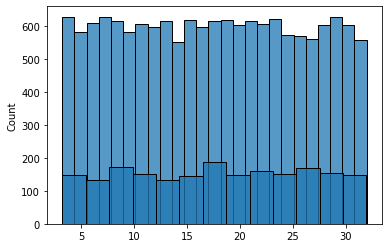

In [42]:
sns.histplot(data=radius_train)
sns.histplot(data=radius_test)
plt.show()

### Guassian Blurring

In [43]:
# Blurring  5X5
# Blurring  5X5
x_train_blury = np.zeros((x_train.shape[0], 64, 64))
x_test_blury =  np.zeros((x_test.shape[0], 64, 64))
for i in range(x_train.shape[0]):
    x_train_blury[i] = cv2.GaussianBlur(x_train[i], (5, 5), 0)
for i in range(x_test.shape[0]):
    x_test_blury[i] =  cv2.GaussianBlur(x_test[i], (5, 5), 0)

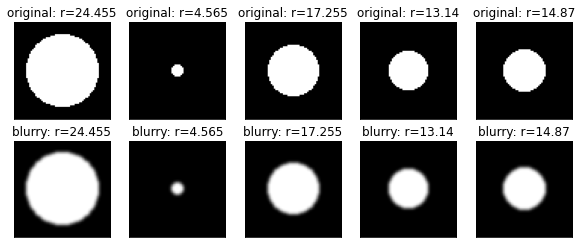

In [44]:
n = 5
plt.figure(figsize=(10, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train[i])
  plt.title("original: r={}".format(radius_train[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(x_train_blury[i])
  plt.title("blurry: r={}".format(radius_train[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [45]:

x_train_blury = x_train_blury.astype('float32') / 255.
x_test_blury  = x_test_blury.astype('float32') / 255.

print (x_train_blury.shape)
print (x_test_blury.shape)

(15000, 64, 64)
(2000, 64, 64)


# Convolutional autoencoder with bias

#### Encoder
The encoder part is pretty standard, we stack convolutional and pooling layers and finish with a dense layer to get the representation of desirable size (code_size).

We recommend to use activation='elu' for all convolutional and dense layers.

We recommend to repeat (conv, pool) 4 times with kernel size (3, 3), padding='same' and the following numbers of output channels: 32, 64, 128, 256.

Remember to flatten (L.Flatten()) output before adding the last dense layer!


#### Decoder
For decoder we will use so-called "transpose convolution".

Traditional convolutional layer takes a patch of an image and produces a number (patch -> number). In "transpose convolution" we want to take a number and produce a patch of an image (number -> patch). We need this layer to "undo" convolutions in encoder. We had a glimpse of it during week 3.


Here's how "transpose convolution" works:  In this example we use a stride of 2 to produce 4x4 output, this way we "undo" pooling as well. Another way to think about it: we "undo" convolution with stride 2 (which is similar to conv + pool).

You can add "transpose convolution" layer in Keras like this:
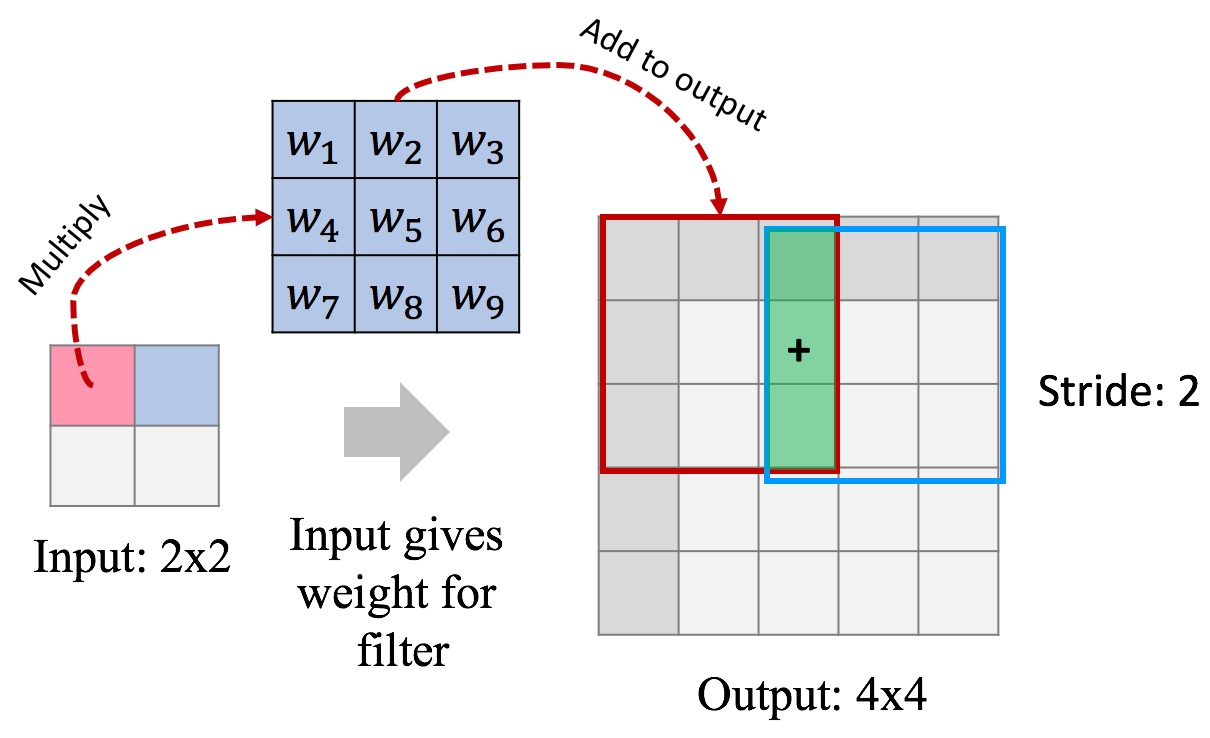

L.Conv2DTranspose(filters=?, kernel_size=(3, 3), strides=2, activation='elu', padding='same')
Our decoder starts with a dense layer to "undo" the last layer of encoder. Remember to reshape its output to "undo" L.Flatten() in encoder.

Now we're ready to undo (conv, pool) pairs. For this we need to stack 4 L.Conv2DTranspose layers with the following numbers of output channels: 128, 64, 32, 3. Each of these layers will learn to "undo" (conv, pool) pair in encoder. For the last L.Conv2DTranspose layer use activation=None because that is our final image.



In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

### Data Preparation for CNN Models

In [46]:
tf.keras.backend.clear_session()
session_conf = tf.compat.v1.ConfigProto( intra_op_parallelism_threads=1, inter_op_parallelism_threads=1 )
sess = tf.compat.v1.Session( graph=tf.compat.v1.get_default_graph(), config=session_conf )
tf.compat.v1.keras.backend.set_session(sess)

In [47]:
num_epochs = 200
batch_size=300

In [48]:
# data prepration into CONV2D
x_train_blury_cnn=x_train_blury[..., np.newaxis]
x_test_blury_cnn=x_test_blury[..., np.newaxis]

In [49]:
print(' train shape dimension {}'.format(x_train_blury_cnn.shape))
print(' test shape dimension {}'.format(x_test_blury_cnn.shape))

 train shape dimension (15000, 64, 64, 1)
 test shape dimension (2000, 64, 64, 1)


In [50]:
print(' train min and max {}, {}'.format(x_train_blury_cnn.min(),x_train_blury_cnn.max()))
print(' test  min and max {}, {}'.format(x_test_blury_cnn.min(),x_test_blury_cnn.max()))

 train min and max 0.0, 1.0
 test  min and max 0.0, 1.0


### Ploting 

In [51]:
class plot_ae():
    def __init__(self, data, layer_name, model):
        self.data=data
        self.model=model
        self.layer_name=layer_name
    
    def encode_predict(self):

        encode_model = Model(inputs= self.model.encoder.input,
                                  outputs=self.model.encoder.get_layer(self.layer_name).output)
        return encode_model.predict(self.data, batch_size=300)
        
    def  decode_predict(self, x):
        decode_model = Model(inputs=self.model.decoder.input,
                                 outputs=self.model.decoder.output)
        return  decode_model.predict(x, batch_size=300)
    
    def plot_reults(self, n, data, data_p, radius, latent, title):
        
        plt.figure(figsize=(20, 4))
        plt.suptitle(title)
        for i in range(n):
            img=random.randint(0, len(radius))

            # display original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(data[img])
            plt.title("r={}, z={}".format('%.2g'%(radius[img]), '%.2g'%(latent[img][0][0][0]) ) )
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(data_p[img])
            plt.title("reconstructed")
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()
    
    def plot_reults_hole(self, n, data, data_p, radius, latent, title, h1, h2):
        
        plt.figure(figsize=(20, 4))
        plt.suptitle(title)
        index_list=[]
        index_list1=[]
        for im in range(len(radius)):
            if radius[im]<=h2 and radius[im]>=h1:
                index_list.append(im)
            else:
                index_list1.append(im) 
                 
        for i in range(n):        
            if i <6:
                img=index_list1[random.randint(0, len(index_list1))]
            else:
                img=index_list[random.randint(0, len(index_list))]
            
            #if radius[img] >=h1 and radius[img] =<h2:
                
            # display original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(data[img])
            plt.title("r={}, z={}".format('%.2g'%(radius[img]), '%.2g'%(latent[img][0][0][0]) ) )
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(data_p[img])
            plt.title("reconstructed")
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()
        
    def plot_reults_prof(self, n, data, data_p, radius, latent, title):
        
        plt.figure(figsize=(20, 6))
        plt.suptitle(title)
        for i in range(n):
            img=random.randint(0, n)
            # display original
            ax = plt.subplot(3, n, i + 1)
            plt.imshow(data[img])
            plt.title("r={}, z={}".format('%.2g'%(radius[img]), '%.2g'%(latent[img][0][0][0]) ) )
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            # display reconstruction
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(data_p[img])
            plt.title("reconstructed")
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            # display reconstruction
            t=np.arange(0,64)
            y= data[img][32]
            yp=data_p[img][32]
            ax = plt.subplot(3, n, i + 1 + n+n)
            plt.plot(t,y, label= 'Disk Profile')
            plt.plot(t,yp,label='Output Profile')
            plt.legend()
            
        plt.show()
        
    def plot_latent(self, data, latent, radius, title ):
        z=[]
        area =[]
        r=[]
        for i in range(data.shape[0]):
            z.append(latent[i][0][0][0])
            area.append((radius[i]*radius[i]*np.pi))
            r.append(radius[i])
            
        fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,4))
        fig.suptitle(title)
        axes[0].set_title('inspect the latent space vs radius')
        axes[1].set_title('inspect the latent space vs area')
        axes[0].set_xlabel('z, latent space')
        axes[1].set_xlabel('z, latent space')
        axes[0].set_ylabel('disk radius')
        axes[1].set_ylabel('disk area')
        sns.scatterplot(ax=axes[0], x=z, y=r)
        sns.scatterplot(ax=axes[1], x=z, y=area)
        plt.show()
        return z, r, area
        

In [52]:
## Standard CNN Architecture (Nelson's Article)

In [53]:

class Denoise(Model):
  def __init__(self):
    activ=LeakyReLU(alpha=0.2)
    l1= tf.keras.regularizers.l1(0.01)
    l2= tf.keras.regularizers.l2(0.01)
    l12=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)
    re=l2
    rd=None
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(64, 64,1), name='en1'),
      layers.ZeroPadding2D( padding=(1, 1) ),
      layers.Conv2D(8, (3, 3), activation=activ, strides=2, name='en2', kernel_initializer='he_normal', kernel_regularizer=re),
      layers.ZeroPadding2D( padding=(1, 1) ),
      layers.Conv2D(4, (3, 3), activation=activ, strides=2, name='en4', kernel_initializer='he_normal', kernel_regularizer=re),
      layers.ZeroPadding2D( padding=(1, 1) ),
      layers.Conv2D(4, (3, 3), activation=activ, strides=2, name='en6', kernel_initializer='he_normal', kernel_regularizer=re),
      layers.ZeroPadding2D( padding=(1, 1) ),
      layers.Conv2D(3, (3, 3), activation=activ, strides=2, name='en8', kernel_initializer='he_normal', kernel_regularizer=re),
      layers.ZeroPadding2D( padding=(1, 1) ),
      layers.Conv2D(2, (3, 3), activation=activ, strides=2, name='en10', kernel_initializer='he_normal',kernel_regularizer=re),
      layers.ZeroPadding2D( padding=(1, 1) ),
      layers.Conv2D(1, (3, 3), activation=activ, strides=2, name='en13', kernel_initializer='he_normal',kernel_regularizer=re),
        ])

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D((2,2), name='de1'),  
      layers.Conv2DTranspose(1,  kernel_size=3,activation=activ,name='de2', padding='same', 
                             kernel_initializer='he_normal', kernel_regularizer=rd),
      layers.UpSampling2D((2,2), name='de3'),  
      layers.Conv2DTranspose(2,  kernel_size=3,activation=activ,name='de4', padding='same', 
                             kernel_initializer='he_normal', kernel_regularizer=rd),
      layers.UpSampling2D((2,2), name='de5'),  
      layers.Conv2DTranspose(3,  kernel_size=3,activation=activ,name='de6', padding='same', 
                             kernel_initializer='he_normal', kernel_regularizer=rd), 
      layers.UpSampling2D((2,2), name='de7'),
      layers.Conv2DTranspose(4,  kernel_size=3,activation=activ,name='de8', padding='same', 
                             kernel_initializer='he_normal', kernel_regularizer=rd),  
      layers.UpSampling2D((2,2), name='de9'),
      layers.Conv2DTranspose(4, kernel_size=3,activation=activ, name='de10',padding='same', 
                             kernel_initializer='he_normal', kernel_regularizer=rd),
      layers.UpSampling2D((2,2), name='de11'),
      layers.Conv2DTranspose(8, kernel_size=3,activation=activ, name='de12', padding='same', 
                             kernel_initializer='he_normal', kernel_regularizer=rd),
      layers.Conv2D(1, kernel_size=3, activation='sigmoid', padding='same', name='de13', 
                    kernel_initializer='he_normal', kernel_regularizer=rd) 
      ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [54]:
autoencoder = Denoise()

In [55]:
#dice coefficient loss function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [56]:
opti=tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False )
opti1=tf.keras.optimizers.RMSprop()
autoencoder.compile(optimizer=opti, loss='mse', metrics=['accuracy'] )

In [57]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 66, 66, 1)        0         
 2D)                                                             
                                                                 
 en2 (Conv2D)                (None, 32, 32, 8)         80        
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 34, 34, 8)        0         
 ng2D)                                                           
                                                                 
 en4 (Conv2D)                (None, 16, 16, 4)         292       
                                                                 
 zero_padding2d_2 (ZeroPaddi  (None, 18, 18, 4)        0         
 ng2D)                                                           
                                                        

In [58]:
# load pretrained weights
#model.load_weights(os.path.join(saveDir,"AE1_UNET_weights.00--0.71--0.72.hdf5"))

## Training with Limited Radius (Hole in DataSet) 

In [59]:
tf.keras.backend.clear_session()
session_conf = tf.compat.v1.ConfigProto( intra_op_parallelism_threads=1, inter_op_parallelism_threads=1 )
sess = tf.compat.v1.Session( graph=tf.compat.v1.get_default_graph(), config=session_conf )
tf.compat.v1.keras.backend.set_session(sess)

In [60]:
h1=5
h2=12
x_train_h=[]
x_train_h_rad=[]
for i in range(x_train_blury_cnn.shape[0]):
    if radius_train[i]>h2 or radius_train[i]<h1 :
        x_train_h.append(x_train_blury_cnn[i])
        x_train_h_rad.append(radius_train[i])
x_train_h=np.array(x_train_h)

In [61]:
print(np.max(radius_train), np.max(radius_test) )
print(np.min(radius_train), np.min(radius_test) )

31.97 31.955
3.205 3.215


In [62]:
x_train_h.shape

(11307, 64, 64, 1)

In [63]:
tf.keras.backend.clear_session()
autoencoder_h1_5 = Denoise()

opti=tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False )
autoencoder_h1_5.compile(optimizer=opti, loss='mse', metrics=['mse'] )


es = EarlyStopping(monitor="val_loss", mode="min", verbose=0, patience=3)
mc = ModelCheckpoint(
    "model", monitor="val_loss", mode="max", verbose=0, save_best_only=True)

histh1_5=autoencoder_h1_5.fit(x_train_h, x_train_h,
                epochs=num_epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_split=0.2, callbacks=[es, mc], verbose=0)

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


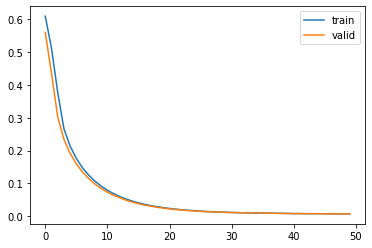

In [64]:
# Capturing learning history per epoch
hist = pd.DataFrame(histh1_5.history)
hist["epoch"] = histh1_5.epoch

# Plotting accuracy at different epochs
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.legend(("train", "valid"), loc=0)

In [65]:
result_train_h=plot_ae(data=x_train_h,         layer_name='en13', model=autoencoder_h1_5 )
result_test_h =plot_ae(data=x_test_blury_cnn,  layer_name='en13', model=autoencoder_h1_5 )

In [66]:
encoded_imgs_train_h= result_train_h.encode_predict()
decoded_imgs_train_h= result_train_h.decode_predict(encoded_imgs_train_h)
decoded_imgs_train_h= decoded_imgs_train_h[:, :, :,0]

38/38 [==============================] - 0s 9ms/step


In [67]:
encoded_imgs_test_h=result_test_h.encode_predict()
decoded_imgs_test_h=result_test_h.decode_predict(encoded_imgs_test_h)
decoded_imgs_test_h=  decoded_imgs_test_h[:, :, :,0]

7/7 [==============================] - 0s 5ms/step


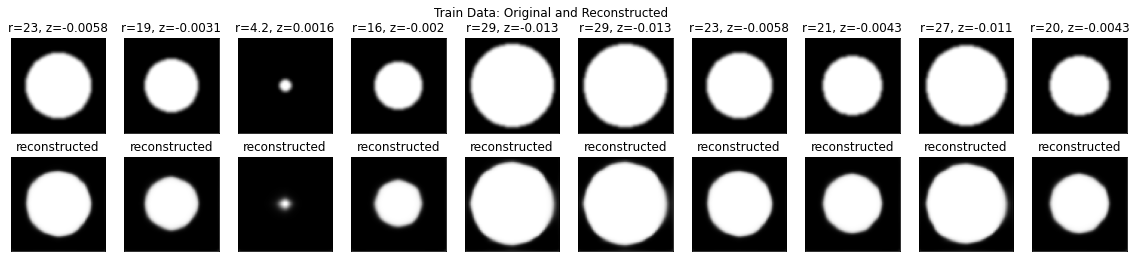

In [68]:
result_train_h.plot_reults(n=10, data=x_train_h, data_p=decoded_imgs_train_h, radius=x_train_h_rad, 
                         latent=encoded_imgs_train_h, title='Train Data: Original and Reconstructed')

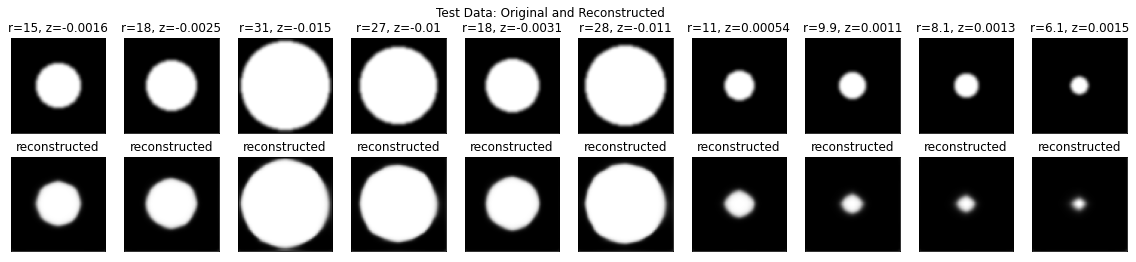

In [69]:
result_test_h.plot_reults_hole(n=10, data=x_test_blury_cnn, data_p=decoded_imgs_test_h, radius=radius_test, 
                         latent=encoded_imgs_test_h, title='Test Data: Original and Reconstructed', h1=h1, h2=h2)

<AxesSubplot:ylabel='Count'>

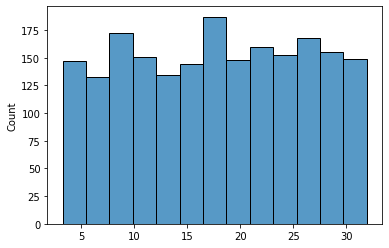

In [70]:
sns.histplot(radius_test)

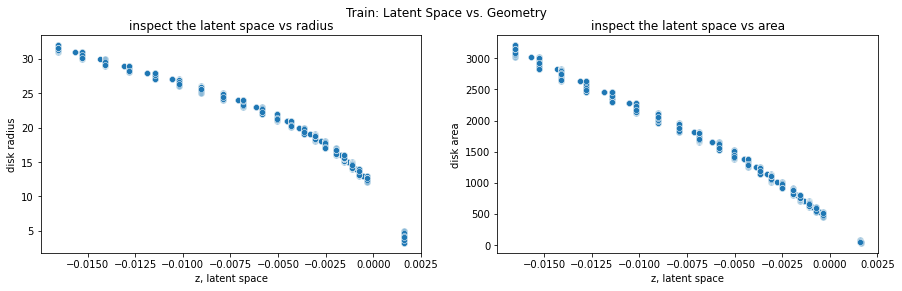

In [71]:
z_train_h1_5, r_train_h1_5, area_train_h1_5= result_train_h.plot_latent(data=x_train_h, latent=encoded_imgs_train_h, radius=x_train_h_rad, 
                           title='Train: Latent Space vs. Geometry' )

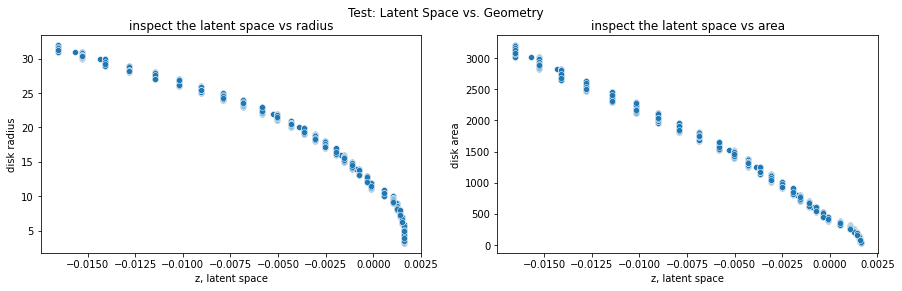

In [72]:
z_test_h1_5, r_test_h1_5, area_test_h1_5= result_test_h.plot_latent(data=x_test_blury_cnn, latent=encoded_imgs_test_h, 
                           radius=radius_test, title='Test: Latent Space vs. Geometry' )

In [73]:
latent_df=pd.DataFrame({'z':z_test_h1_5, 
                     'r': r_test_h1_5, 
                     'area':area_test_h1_5})

In [74]:
#autoencoder_h1_5.save(saveDir+'AEh10_15')
#hist.to_csv(saveDir+'AEh10_15.csv')
#latent_df.to_csv(saveDir+'latent_df_h10_15.csv')